# Overview:

## Get instantaneous sensitivities

In [1]:
import sensitivity_calculator as sens
import numpy as np
import matplotlib.pyplot as plt

# t_filter_cold and feedhorn beam file used for spill calculations should be refined further.

inputs = {'diameter': 5.7, 't': 273, 'wfe': 10.7, 'eta': 0.98, 'doe': 0.8, 't_int': 1, 'pixelYield': 0.8, 
        'szCamNumPoln': 1, 'eorSpecNumPoln': 2, 't_filter_cold': np.array([0.593, 0.84 , 0.909, 0.922, 0.89 ]), 
        't_lens_cold': np.array([0.98, 0.98, 0.98, 0.98, 0.98]), 
        't_uhdpe_window': np.array([0.96, 0.97, 0.97, 0.97, 0.97]), 
        'singleModedAOmegaLambda2': np.array([1., 1., 1., 1., 1.]), 
        'spatialPixels': np.array([39762, 20808, 10368, 10368,  7938]), 
        'eqbw': np.array([9.7e+10, 3.0e+10, 3.6e+10, 7.0e+10, 5.6e+10]), 
        'centerFrequency': np.array([8.50e+11, 4.05e+11, 3.48e+11, 2.85e+11, 2.22e+11]), 'detectorNEP': 0, 
        'backgroundSubtractionDegradationFactor': 1, 'r': np.array([[100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.]]), 
        'decimalPlaces': 3, 'observationElevationAngle': 55, 'outputFreq': True, 
        'detectorSpacing': np.array([1.45, 1.97, 2.75, 2.75, 3.13]), 'lyotStopAngle': 13.4}
# Alternatively, sens.getInputs("input.yaml")

spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=True)
print(spillEfficiency)
calculate = sens.calcByAngle(inputs["diameter"], inputs["t"], inputs["wfe"], inputs["eta"], inputs["doe"], inputs["t_int"], inputs["pixelYield"], inputs["szCamNumPoln"], inputs["eorSpecNumPoln"],
                            inputs["t_filter_cold"], inputs["t_lens_cold"], inputs["t_uhdpe_window"], spillEfficiency, inputs["singleModedAOmegaLambda2"],
                            inputs["spatialPixels"], inputs["eqbw"], inputs["centerFrequency"], inputs["detectorNEP"],
                            inputs["backgroundSubtractionDegradationFactor"], inputs["r"])
# elevation 55 deg
outputs = calculate(55)

print("beam: ", outputs["beam"])
print("NEP weighted avrage: ", outputs['netW8Avg'])

[0.76390292 0.49038857 0.60958542 0.47873857 0.40693271]
beam:  [15.31558919 32.14382916 37.4087667  45.67807302 58.64076942]
NEP weighted avrage:  [2.33602827e+05 2.26122407e+02 7.17862876e+01 1.56594703e+01
 8.53202739e+00]


## Get integrated noise curves for GAMA-9

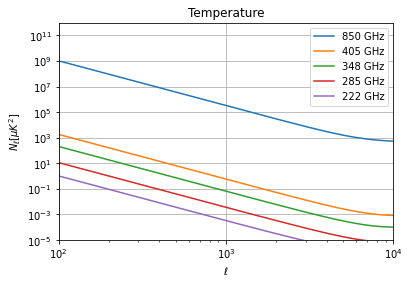

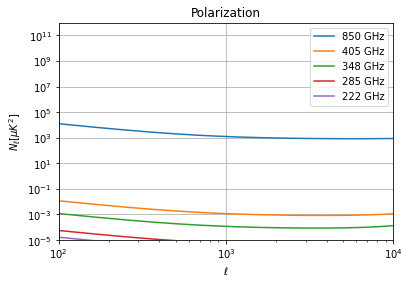

In [11]:
ell, N_ell_T_full, N_ell_P_full = sens.getNoiseCurves(inputs, outputs, survey_hours = 2000, el = 55. , sky_area = 165.)

for curves, labels, title in zip([N_ell_T_full, N_ell_P_full], [inputs["centerFrequency"]] * 2, ["Temperature", "Polarization"]):
    for curve, label in zip(curves, labels):
        plt.plot(ell, curve, label=str(int(label/1e9))+' GHz')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(10**2, 10**4)
    plt.ylim(10**-5, 10**12)
    plt.xlabel('$\ell$')
    plt.ylabel('$N_\ell [\mu K^2]$')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

## GAMA-9 noise simulations

f_sky: 0.003996157155846102
sky_area: 164.85331629670875


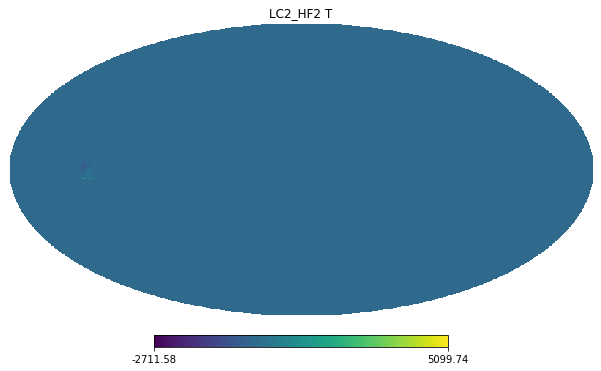

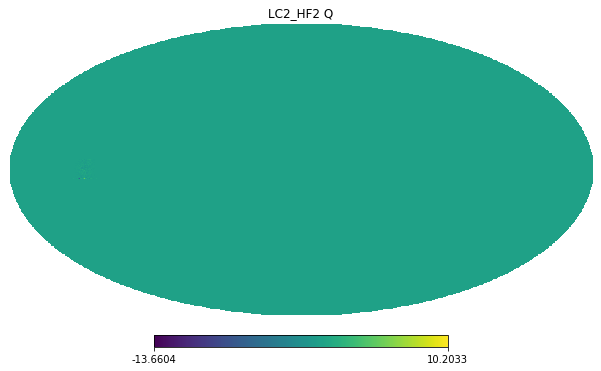

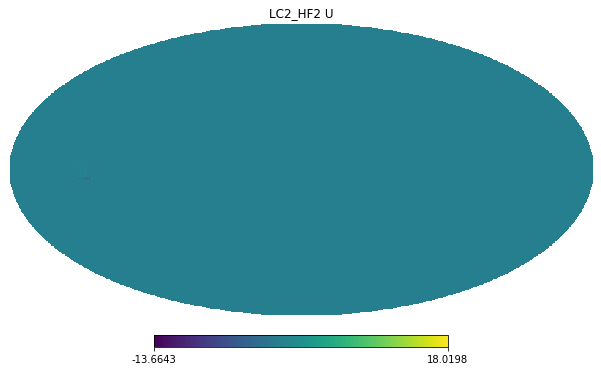

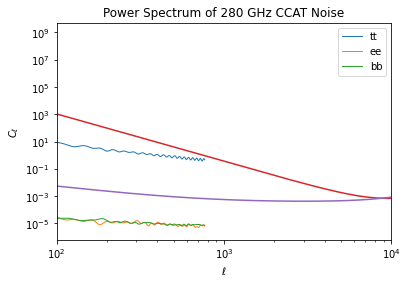

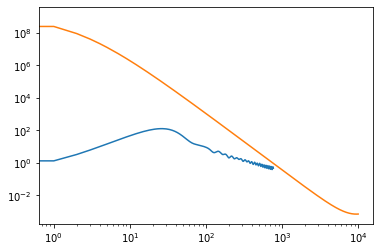

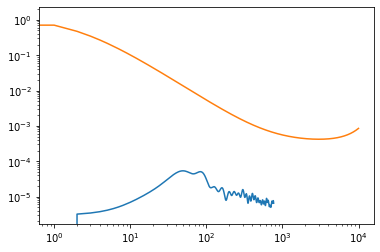

<Figure size 432x288 with 0 Axes>

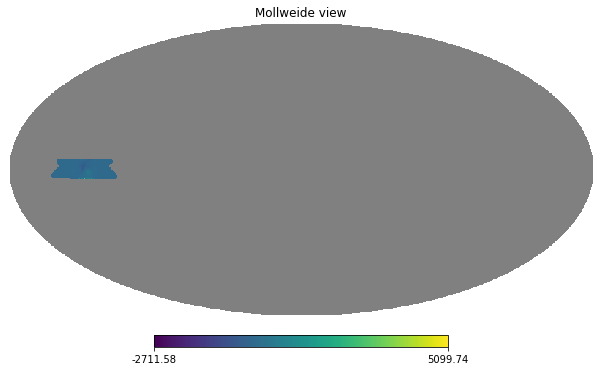

<Figure size 432x288 with 0 Axes>

In [10]:
# %matplotlib notebook

import healpy as hp

seed = 0
NSIDE = 256
hitmap_path = "src/sensitivity_calculator/data/gama9_hit_map_healpix_nside" + str(NSIDE) + "_231218.fits"
# zf = sens.zeroHitmapFraction(hitmap_path, NSIDE)
def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4

hitmap = hp.ud_grade(
            hp.read_map(hitmap_path, dtype=np.float64),
            nside_out=NSIDE,
        )

hitm = hp.read_map(hitmap_path)
zf = get_hivon_fsky(hitm)
sky_area = zf*4*np.pi*(180/np.pi)**2

print("f_sky:", zf)
print("sky_area:", sky_area)

data_C = sens.sensitivity._data_C_calcV2(inputs)

for pysm_components, sim_noise in zip([None], [True]):
    ccat280 = sens.ccat_mapsims(
        inputs, outputs, "HF2", "LC2", pysm_components, seed, data_C, sim_cmb=False, sim_noise=sim_noise, hitmap_path=hitmap_path, NSIDE=NSIDE)
    ccat280cls = hp.sphtfunc.anafast(ccat280)
    sens.plotPowerSpectrum(ccat280cls[0], ccat280cls[1], ccat280cls[2],
                      "280 GHz CCAT " + ("Noise" if sim_noise else "Signal"), zf=zf, TT_theory=N_ell_T_full[3], PP_theory=N_ell_P_full[3])


plt.close()

ccat280cls = hp.sphtfunc.anafast(ccat280)
plt.plot(ccat280cls[0]/zf)
plt.plot(N_ell_T_full[3])
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.clf()

plt.plot(ccat280cls[1]/zf)
plt.plot(N_ell_P_full[3])
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.clf()

ccat280[ccat280==0] = hp.UNSEEN
hp.mollview(ccat280[0])
plt.show()
plt.clf()


## Get integrated noise curves for DEEP56

In [ ]:
ell, N_ell_T_full, N_ell_P_full = sens.getNoiseCurves(inputs, outputs, survey_hours = 100, el = 55. , sky_area = 500.)

for curves, labels, title in zip([N_ell_T_full, N_ell_P_full], [inputs["centerFrequency"]] * 2, ["Temperature", "Polarization"]):
    for curve, label in zip(curves, labels):
        plt.plot(ell, curve, label=str(int(label/1e9))+' GHz')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(10**2, 10**4)
    plt.ylim(10**-5, 10**12)
    plt.xlabel('$\ell$')
    plt.ylabel('$N_\ell [\mu K^2]$')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

## DEEP56 noise simulations

f_sky: 0.003996157155846102
sky_area: 164.85331629670875


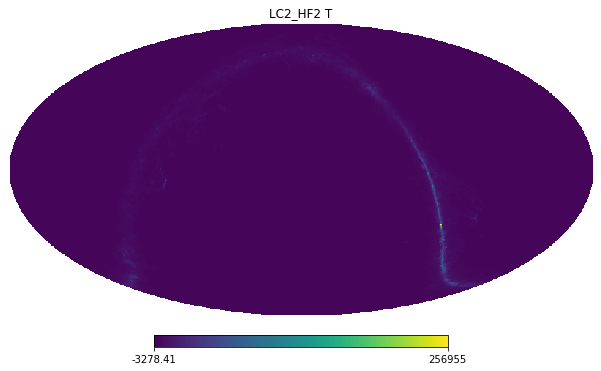

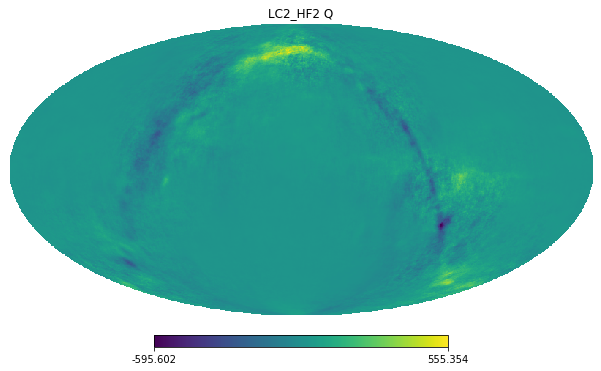

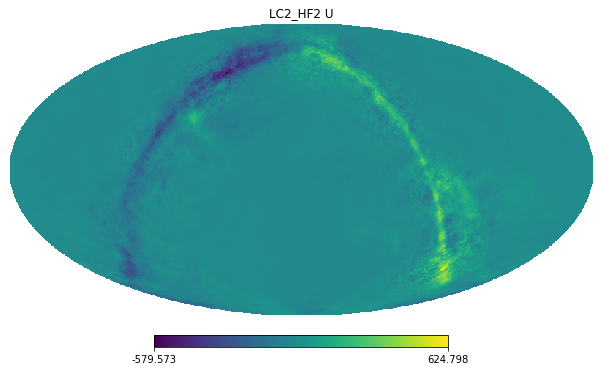

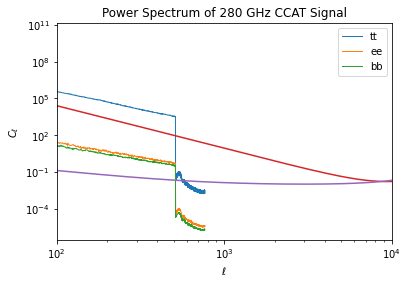

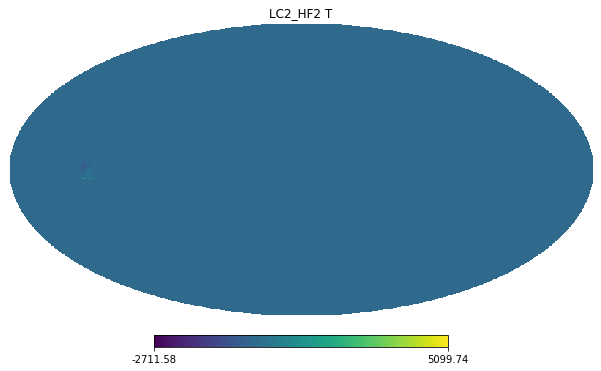

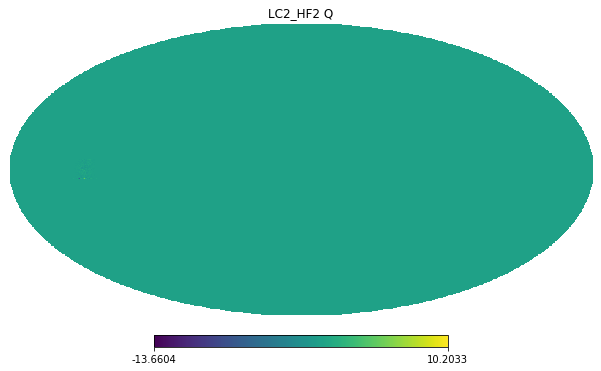

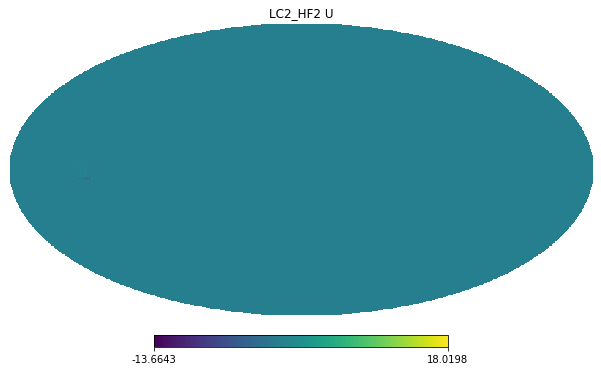

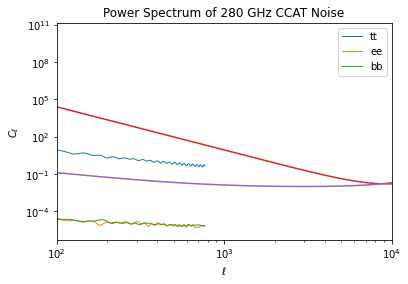

In [3]:
import healpy as hp

seed = 0
NSIDE = 256
hitmap_path = "src/sensitivity_calculator/data/deep56_hit_map_healpix_nside" + str(NSIDE) + "_231218.fits"
# zf = sens.zeroHitmapFraction(hitmap_path, NSIDE)
def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4

hitmap = hp.ud_grade(
            hp.read_map(hitmap_path, dtype=np.float64),
            nside_out=NSIDE,
        )

hitm = hp.read_map(hitmap_path)
zf = get_hivon_fsky(hitm)
sky_area = zf*4*np.pi*(180/np.pi)**2

print("f_sky:", zf)
print("sky_area:", sky_area)

data_C = sens.sensitivity._data_C_calcV2(inputs)

for pysm_components, sim_noise in zip(["d2,cib1", None], [False, True]):
    ccat280 = sens.ccat_mapsims(
        inputs, outputs, "HF2", "LC2", pysm_components, seed, data_C, sim_cmb=False, sim_noise=sim_noise, hitmap_path=hitmap_path, NSIDE=NSIDE)
    ccat280cls = hp.sphtfunc.anafast(ccat280)
    sens.plotPowerSpectrum(ccat280cls[0], ccat280cls[1], ccat280cls[2],
                      "280 GHz CCAT " + ("Noise" if sim_noise else "Signal"), zf=zf, TT_theory=N_ell_T_full[3], PP_theory=N_ell_P_full[3])
